### Import necessary packages and the scikit-learn diabetes dataset

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from tabularmagic import TabularMagic
from tabularmagic.ml import Linear, Tree, TreeEnsemble, SVM, MLP

diabetes_data = load_diabetes()
df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)
df['target'] = diabetes_data.target
display(df.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Create a TabularMagic object

UPDATE: TabularMagic initialization complete. Train, test dataset shapes: ((353, 11), (89, 11))


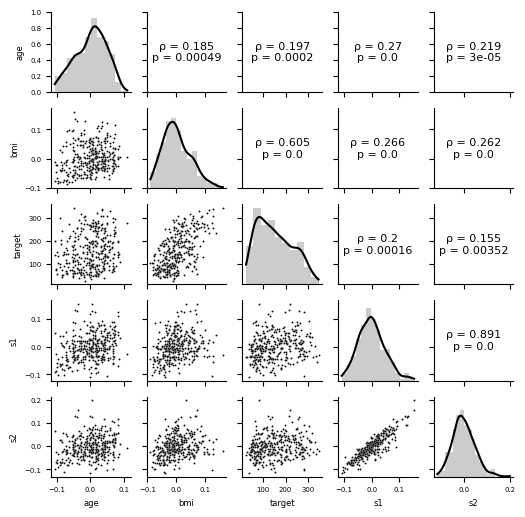

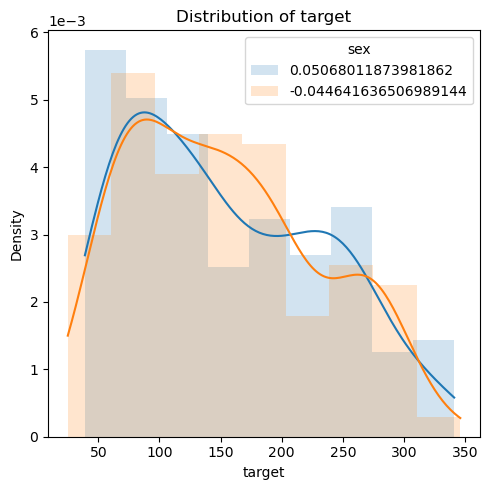

In [4]:
tm = TabularMagic(df, test_size=0.2)
train_eda = tm.eda()
display(train_eda.plot_continuous_pairs(continuous_vars=['age', 'bmi', 'target', 's1', 's2']))
display(train_eda.plot_distribution_stratified('target', 'sex', include_hist=True))
pca_labels = train_eda.df['sex'] == train_eda.df['sex'].unique()[0]

### Basic regression analysis

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     138.2
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           4.99e-59
Time:                        00:20:24   Log-Likelihood:                -1942.0
No. Observations:                 353   AIC:                             3892.
Df Residuals:                     349   BIC:                             3908.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        149.7828      3.695     40.540      0.000     142.541     157.024
bmi          833.6502     77.705     10.728      0.000     681.352     985.949
bp           375.6923     75.818      4.955      0.000     227.091     524.294
bp*bmi      2285.4523   1153.687      1.981      0.048      24.266    4546.638
==============================================================================
Omnibus:                       10.349   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                6.811
Skew:                           0.196   Prob(JB):                       0.0332
Kurtosis:                       2.444   Cond. No.                         407.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

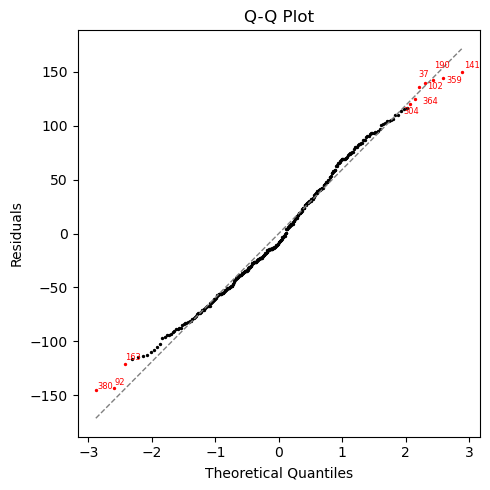

In [4]:
X_vars = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
y_var = 'target'

train_report, test_report = tm.lm_rlike('target ~ bmi + bp + bp * bmi')
train_report.set_outlier_threshold(2)
display(train_report.statsmodels_summary())
train_report.plot_qq(standardized=False, show_outliers=True)

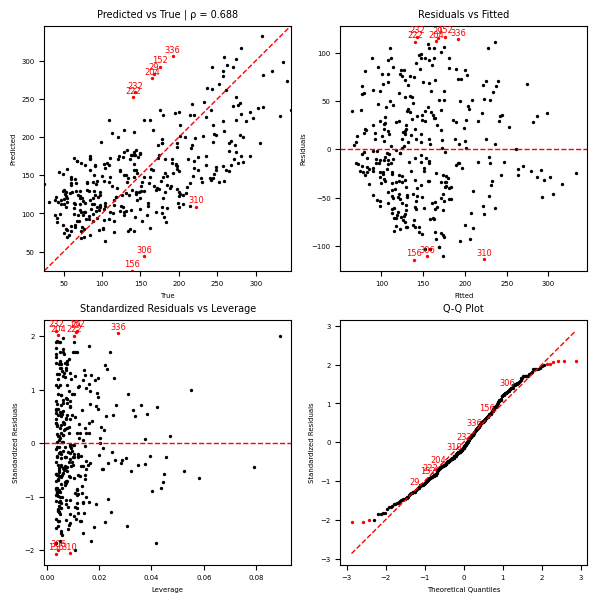

In [ ]:
tm.reset_working_dfs()
tm.drop_train_examples(train_report.get_outlier_indices())
tm.set_working_df_checkpoint('drop_checkpoint')
train_report, test_report = tm.lm_rlike('target ~ bmi + bp + bp * bmi', inverse_scale_y=True)
display(train_report.plot_diagnostics(show_outliers=True))

### Define a sequence of models

In [4]:
models = [
    # All models have default hyperparameter search methods built in.
    Linear(regularization_type=None, n_jobs=-1),
    Linear(regularization_type='l1', n_jobs=-1),
    Linear(regularization_type='l2', n_jobs=-1),

    # You can manually set the inner cross validation details
    Tree(n_jobs=-1, random_state=42, inner_cv=10, inner_cv_seed=0, 
         verbose=1),

    TreeEnsemble(ensemble_type='random_forest', n_jobs=-1, random_state=42),
    TreeEnsemble(ensemble_type='xgboost', n_jobs=-1),

    # You can manually set the nickname of a model
    SVM(kernel='rbf', nickname='SVM(rbf)', n_jobs=-1),
    
    # You can manually specify the hypeparameter search method
    # in an sklearn-like manner. 
    MLP(
        hyperparam_search_method='grid',
        hyperparam_grid_specification={
            'hidden_layer_sizes': [(50), (100), (50, 50)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200]
        }
    )
]

### Conduct a benchmarking exercise with the specified models

In [5]:
train_report, test_report = tm.ml_regression_benchmarking(
    X_vars=X_vars,
    y_var=y_var,
    models=models,
    outer_cv=None,
)

Task 1 of 8.	Fitting Linear(None).


Task 2 of 8.	Fitting Linear(l1).
Task 3 of 8.	Fitting Linear(l2).
Task 4 of 8.	Fitting Tree.
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Task 5 of 8.	Fitting TreeEnsemble(random_forest).
Task 6 of 8.	Fitting TreeEnsemble(xgboost).
Task 7 of 8.	Fitting SVM(rbf).
Task 8 of 8.	Fitting MLP.


### View the train and test model metrics

In [9]:
display(train_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(xgboost),SVM(rbf),MLP
Statistic,,,,,,,,
mse,2868.549703,2891.088744,2869.991159,2562.652844,1792.060422,3047.679270,2807.084759,4089.836710
mad,43.483504,43.702299,43.493094,40.332560,35.733170,47.439121,42.043076,53.824454
pearsonr,0.726581,0.724166,0.726421,0.760435,0.861124,0.795487,0.735274,0.632129
spearmanr,0.711415,0.708528,0.710574,0.750717,0.844912,0.780760,0.719210,0.635213
r2,0.527919,0.524210,0.527682,0.578261,0.705078,0.498440,0.538035,0.326931
adjr2,0.514116,0.510298,0.513872,0.565930,0.696455,0.483774,0.524527,0.307250
n,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000


In [10]:
display(test_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(xgboost),SVM(rbf),MLP
Statistic,,,,,,,,
mse,2900.193628,2849.994101,2892.680181,3724.096842,2865.233132,3220.088490,2858.147774,3551.044710
mad,42.794095,42.831542,42.810164,48.089086,43.687690,48.877974,42.099962,49.989166
pearsonr,0.677973,0.682701,0.678575,0.586130,0.678833,0.691185,0.686508,0.614742
spearmanr,0.667263,0.665254,0.664062,0.576604,0.638490,0.679815,0.659822,0.593423
r2,0.452603,0.462078,0.454021,0.297095,0.459201,0.392224,0.460539,0.329758
adjr2,0.382424,0.393113,0.384024,0.206979,0.389868,0.314304,0.391377,0.243829
n,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000


### View the predicted vs true scatter plot of the SVM model on testing data.

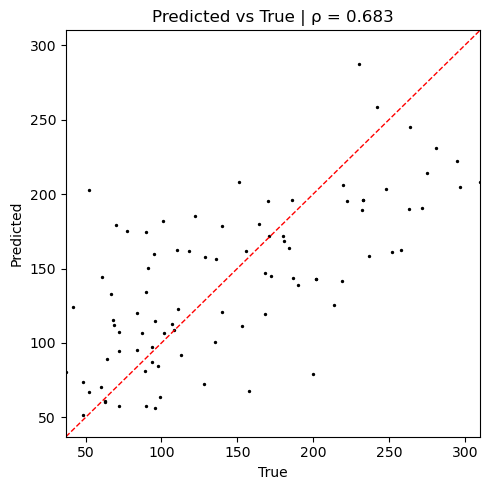

In [12]:
fig = test_report['Linear(l1)'].plot_pred_vs_true()
fig